# Introduction

This notebook will illustrate experiments with the Adam optimizer in TensorFlow to solve the `lagaris_05` coupled PDE BVP.

## The `lagaris05` ODE problem

This PDE was used as the fifth example problem in (Lagaris et al., 1998). The differential equation is provided in the form (equation (32) in Lagaris (1998)):

\begin{equation}
    \nabla^2 \psi (x,y) = e^{-x} \left( x - 2 + y^3 + 6y \right)
\end{equation}

or:

\begin{equation}
    G \left( x, y, \psi, \frac {\partial \psi} {dx}, \frac {\partial \psi} {\partial y}, \frac {\partial^2 \psi} {dx^2} \frac {\partial^2 \psi} {\partial y^2} \right) = \frac {\partial^2 \psi} {\partial x^2} + \frac {\partial^2 \psi} {dy^2} - e^{-x} \left( x - 2 + y^3 + 6y \right) = 0
\end{equation}

with initial conditions:

\begin{equation}
    \psi(0, y) = y^3 \\
    \psi(1, y) = ( 1 + y^3 ) e^{-1} \\
    \psi(x, 0) = x e^{-x} \\
    \psi(x, 1) = e^{-x} (x + 1)
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x, y) = e^{-x} (x + y^3)
\end{equation}

The derivatives are:

\begin{equation}
    \frac {\partial \psi} {\partial x} = e^{-x} ( 1 - x - y^3) \\
    \frac {\partial \psi} {\partial y} = 3 e^{-x} y^2 \\
    \frac {\partial^2 \psi} {\partial x^2} = e^{-x} ( -2 + x + y^3) \\
    \frac {\partial^2 \psi} {\partial y^2} = 6 e^{-x} y
\end{equation}

The analytical solutions and derivatives in the domain $0 \leq x,y \leq 1$ are plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
from math import exp
import os
import platform
import sys

# Import 3rd-party modules.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Import TensorFlow.
import tensorflow as tf

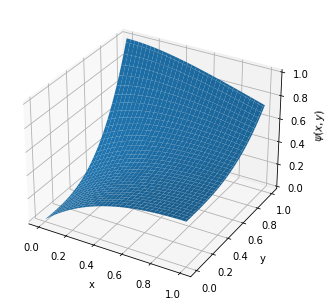

In [2]:
# Import the problem definition.
eq_name = "lagaris05"
eq_module = 'nnde.differentialequation.examples.lagaris_05'
eq = importlib.import_module(eq_module)

# Compute the analytical solution and derivatives.
# Note that Y is used in place of \psi in the code.
na = 101
xa = np.linspace(0, 1, na)
ya = np.linspace(0, 1, na)
Ya = [[eq.Ya([x, y]) for x in xa] for y in ya]
Ya = np.array(Ya)
# dYa_dx = [eq.dY1a_dx(x) for x in xa]
# dYa_dx = [eq.dY2a_dx(x) for x in xa]

# Plot the analytical solution and derivatives.
fig = plt.figure()
(X, Y) = np.meshgrid(xa, ya)
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Ya)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi(x,y)$')
plt.show()

## Solving `lagaris05` using TensorFlow

In [3]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [4]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [5]:
from nnde.math.trainingdata import create_training_grid

def create_training_data(nt):
    x_train = np.array(create_training_grid([nt, nt]))
    return x_train

In [6]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [7]:
print_system_information()

System report:
2021-09-18 16:48:37.999110
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Mon Aug 30 06:12:21 PDT 2021; root:xnu-7195.141.6~3/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
Python build: ('default', 'Aug  6 2021 08:56:27')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [21]:
# Buid and train the model.

# Set up the output directory.
path = "./lagaris_05_tf_adam"
output_dir = create_output_directory(path)

# Training optimizer
training_algorithm = "Adam"

# Initial parameter ranges
w0_range = [-1, 1]
u0_range = [-1, 1]
v0_range = [-1, 1]

# Number of hidden nodes.
H = 10

# Number of training points in each dimension.
nt = 10

# Number of validation points in each dimension.
nv = 100

# Number of training epochs.
n_epochs = 1000

# Learning rate.
learning_rate = 0.01

# Random number generator seed.
random_seed = 0

# Create and save the training data, then convert to Variable.
xyt = create_training_data(nt)
xt = xyt[:, 0]
yt = xyt[:, 1]
np.savetxt(os.path.join(output_dir,'xyt.dat'), xyt)
xytv = tf.Variable(xyt, dtype=tf.float32)
xtv = tf.Variable(xt.reshape((nt*nt,1)), dtype=tf.float32)
ytv = tf.Variable(yt.reshape((nt*nt,1)), dtype=tf.float32)

# Build the model.
model = build_model(H, w0_range, u0_range, v0_range)

# Create history variables.
losses = []
phist = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Create the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Train the model.

# Rename the training data Variable for convenience, just for training.
xy = xytv
x = xtv
y = ytv

print("Hyperparameters: nt = %s, H = %s, n_epochs = %s, learning_rate = %s"
      % (nt, H, n_epochs, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(n_epochs):
#     print("Starting epoch %s." % epoch)

    # Run the forward pass.
    with tf.GradientTape(persistent=True) as tape3:
        with tf.GradientTape(persistent=True) as tape2:
            with tf.GradientTape(persistent=True) as tape1:

                # Compute the network output.
                N = model(xy)

#                 # Compute the trial solution.
#                 A = (
#                     (1 - x)*y**3 +
#                     x*(1 + y**3)*exp(-1) +
#                     (1 - y)*x*(tf.math.exp(-x) - exp(-1)) +
#                     y*((1 + x)*tf.math.exp(-x) - (1 - x - 2*x*exp(-1)))
#                 )
# #                 A = ((1 - xy[:, 0])*xy[:, 1]**3 +
# #                      xy[:, 0]*(1 + xy[:, 1]**3)*exp(-1) +
# #                      (1 - xy[:, 1])*xy[:, 0]*(tf.math.exp(-xy[:, 0]) - exp(-1)) +
# #                      xy[:, 1]*((1 + xy[:, 0])*tf.math.exp(-xy[:, 0]) -
# #                               (1 - xy[:, 0] - 2*xy[:, 0]*exp(-1)))
# #                 ).numpy().reshape((nt*nt, 1))
#                 Y = A + x*(1 - x)*y*(1 - y)*N
# #                 Y = A + xy[:, 0]*(1 - xy[:, 0])*xy[:, 1]*(1 - xy[:, 1])*N

#             # Compute the gradient of trial solution wrt inputs.
#             dY_dx, dY_dy = tape1.gradient(Y, (x, y))
# #             dY_dx = tape1.gradient(Y, xy)

#         # Compute the Laplacian of trial solution wrt inputs.
#         d2Y_dx2 = tape2.gradient(dY_dx, x)
#         d2Y_dy2 = tape2.gradient(dY_dy, y)
# #         d2Y_dx2 = tape2.gradient(dY_dx, xy)

#         # Compute the estimates of the differential equations.
#         G = d2Y_dx2 + d2Y_dy2 - tf.math.exp(x)*(x - 2 + y**3 + 6*y)
# #         G = d2Y_dx2[:, 0] + d2Y_dx2[:, 1] - tf.math.exp(x[:, 0])*(x[:, 0] - 2 + x[:, 1]**3 + 6*x[:, 1])

#         # Compute the loss function.
#         L = tf.math.sqrt(tf.reduce_sum(G**2)/nt)

#         # Save the current losses.
#         losses.append(L.numpy())

#     # Compute the gradient of the loss function wrt the network parameters.
#     pgrad = tape3.gradient(L, model.trainable_variables)

#     # Save the parameters used in this pass.
#     phist.append(
#         np.hstack(
#             (model.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
#              model.trainable_variables[1].numpy(),       # u (H,) row vector
#              model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
#         )
#     )

#     # Update the parameters for this pass.
#     optimizer.apply_gradients(zip(pgrad, model.trainable_variables))

# #     print("Ending epoch %s." % epoch)

# t_stop = datetime.datetime.now()
# print("Training stopped at", t_stop)
# t_elapsed = t_stop - t_start
# print("Total training time was %s seconds." % t_elapsed.total_seconds())

# # Save the parameter histories.
# np.savetxt(os.path.join(output_dir, 'phist.dat'), np.array(phist))

# # Compute and save the trained results at training points.
# xy = xytv
# x = tf.Variable(xy[:, 0].numpy().reshape((nt*nt, 1)))
# y = tf.Variable(xy[:, 1].numpy().reshape((nt*nt, 1)))
# with tf.GradientTape(persistent=True) as tape2:
#     with tf.GradientTape(persistent=True) as tape1:
#         N = model(xy)
#         A = (
#             (1 - x)*y**3 +
#             x*(1 + y**3)*exp(-1) +
#             (1 - y)*x*(tf.math.exp(-x) - exp(-1)) +
#             y*((1 + x)*tf.math.exp(-x) - (1 - x - 2*x*exp(-1)))
#         )
#         Ytt = A + x*(1 - x)*y*(1 - y)*N
#     dYtt_dx, dYtt_dy = tape1.gradient(Ytt, (x, y))
# d2Ytt_dx2 = tape2.gradient(dYtt_dx, x)
# d2Ytt_dy2 = tape2.gradient(dYtt_dy, y)
# np.savetxt(os.path.join(output_dir, 'Ytt.dat'), Ytt.numpy().reshape((nt*nt)))
# np.savetxt(os.path.join(output_dir, 'dYtt_dx.dat'), dYtt_dx.numpy().reshape((nt*nt)))
# np.savetxt(os.path.join(output_dir, 'dYtt_dy.dat'), dYtt_dy.numpy().reshape((nt*nt)))
# np.savetxt(os.path.join(output_dir, 'd2Ytt_dx2.dat'), d2Ytt_dx2.numpy().reshape((nt*nt)))
# np.savetxt(os.path.join(output_dir, 'd2Ytt_dy2.dat'), d2Ytt_dy2.numpy().reshape((nt*nt)))

# # Compute and save the analytical solution and derivative at training points.
# Yat = np.array([eq.Ya(xy) for xy in xyt])
# np.savetxt(os.path.join(output_dir,'Yat.dat'), Yat)
# dYat_dx = np.array([eq.dYa_dx(xy) for xy in xyt])
# dYat_dy = np.array([eq.dYa_dy(xy) for xy in xyt])
# np.savetxt(os.path.join(output_dir,'dYat_dx.dat'), dYat_dx)
# np.savetxt(os.path.join(output_dir,'dYat_dy.dat'), dYat_dy)
# d2Yat_dx2 = np.array([eq.d2Ya_dx2(xy) for xy in xyt])
# d2Yat_dy2 = np.array([eq.d2Ya_dy2(xy) for xy in xyt])
# np.savetxt(os.path.join(output_dir,'d2Yat_dx2.dat'), d2Yat_dx2)
# np.savetxt(os.path.join(output_dir,'d2Yat_dy2.dat'), d2Yat_dy2)

# # Compute and save the error in the trained solution and derivative at training points.
# Ytt_err = Ytt.numpy().reshape((nt*nt)) - Yat
# np.savetxt(os.path.join(output_dir, 'Ytt_err.dat'), Ytt_err)
# dYtt_dx_err = dYtt_dx.numpy().reshape((nt*nt)) - dYat_dx
# dYtt_dy_err = dYtt_dy.numpy().reshape((nt*nt)) - dYat_dy
# np.savetxt(os.path.join(output_dir, 'dYtt_dx_err.dat'), dYtt_dx_err)
# np.savetxt(os.path.join(output_dir, 'dYtt_dy_err.dat'), dYtt_dy_err)
# d2Ytt_dx2_err = d2Ytt_dx2.numpy().reshape((nt*nt)) - d2Yat_dx2
# d2Ytt_dy2_err = d2Ytt_dy2.numpy().reshape((nt*nt)) - d2Yat_dy2
# np.savetxt(os.path.join(output_dir, 'd2Ytt_dx2_err.dat'), d2Ytt_dx2_err)
# np.savetxt(os.path.join(output_dir, 'd2Ytt_dy2_err.dat'), d2Ytt_dy2_err)

# Compute the validation points (xv).
# xyv = create_training_data(nv)
# np.savetxt(os.path.join(output_dir,'xyv.dat'), xyv)
# xyvv = tf.Variable(xyv, dtype=tf.float32)

# xy = xyvv
# x = tf.Variable(xyv[:, 0].numpy().reshape((nv*nv, 1)))
# y = tf.Variable(xyv[:, 1].numpy().reshape((nv*nv, 1)))
# with tf.GradientTape(persistent=True) as tape2:
#     with tf.GradientTape(persistent=True) as tape1:
#         N = model(xy)
#         A = (
#             (1 - x)*y**3 +
#             x*(1 + y**3)*exp(-1) +
#             (1 - y)*x*(tf.math.exp(-x) - exp(-1)) +
#             y*((1 + x)*tf.math.exp(-x) - (1 - x - 2*x*exp(-1)))
#         )
#         Ytv = A + x*(1 - x)*y*(1 - y)*N
#     dYtv_dx, dYtv_dy = tape1.gradient(Ytv, (x, y))
# d2Ytv_dx2 = tape2.gradient(dYtv_dx, x)
# d2Ytv_dy2 = tape2.gradient(dYtv_dy, y)
# np.savetxt(os.path.join(output_dir, 'Ytv.dat'), Ytv.numpy().reshape((nt*nt)))
# np.savetxt(os.path.join(output_dir, 'dYtv_dx.dat'), dYtv_dx.numpy().reshape((nt*nt)))
# np.savetxt(os.path.join(output_dir, 'dYtv_dy.dat'), dYtv_dy.numpy().reshape((nt*nt)))
# np.savetxt(os.path.join(output_dir, 'd2Ytv_dx2.dat'), d2Ytv_dx2.numpy().reshape((nt*nt)))
# np.savetxt(os.path.join(output_dir, 'd2Ytv_dy2.dat'), d2Ytv_dy2.numpy().reshape((nt*nt)))

# Compute and save the analytical solution and derivative at validation points (Yat).
# Y1av = np.array([eq.Y1a(x) for x in xv])
# np.savetxt(os.path.join(output_dir,'Y1av.dat'), Y1av)
# dY1av_dx = np.array([eq.dY1a_dx(x) for x in xv])
# np.savetxt(os.path.join(output_dir,'dY1av_dx.dat'), dY1av_dx)
# Y2av = np.array([eq.Y2a(x) for x in xv])
# np.savetxt(os.path.join(output_dir,'Y2av.dat'), Y2av)
# dY2av_dx = np.array([eq.dY2a_dx(x) for x in xv])
# np.savetxt(os.path.join(output_dir,'dY2av_dx.dat'), dY2av_dx)

# Compute and save the error in the trained solution and derivative at validation points (Ytt_err).
# Y1tv_err = Y1tv.numpy().reshape((nv)) - Y1av
# np.savetxt(os.path.join(output_dir, 'Y1tv_err.dat'), Y1tv_err)
# dY1tv_dx_err = dY1tv_dx.numpy().reshape((nv)) - dY1av_dx
# np.savetxt(os.path.join(output_dir, 'dY1tv_dx_err.dat'), dY1tv_dx_err)
# Y2tv_err = Y2tv.numpy().reshape((nv)) - Y2av
# np.savetxt(os.path.join(output_dir, 'Y2tv_err.dat'), Y2tv_err)
# dY2tv_dx_err = dY2tv_dx.numpy().reshape((nv)) - dY2av_dx
# np.savetxt(os.path.join(output_dir, 'dY2tv_dx_err.dat'), dY2tv_dx_err)

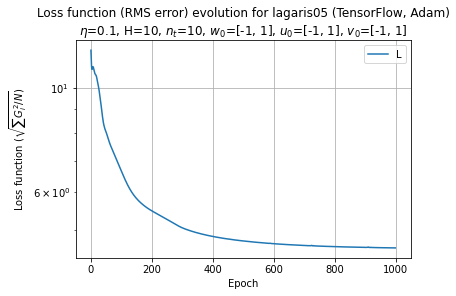

In [14]:
# Plot the loss function history.
plt.semilogy(losses, label="L")
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.legend()
plt.title("Loss function (RMS error) evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.show()

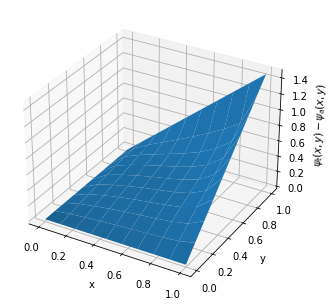

In [15]:
# Plot the error in the trained solution at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(xt, yt)
Z = Ytt_err.reshape((nt, nt))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi_t(x,y)-\psi_a(x,y)$')
plt.show()

In [11]:
# Plot the errors in the trained solution at the validation points.
# fig = plt.figure()
# (X, Y) = np.meshgrid(xt, yt)
# Z = Ytt_err.reshape((nt, nt))
# ax = Axes3D(fig, auto_add_to_figure=False)
# fig.add_axes(ax)
# ax.plot_surface(X, Y, Z)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('$\psi_t(x,y)-\psi_a(x,y)$')
# plt.show()

In [12]:
# # Plot the parameter histories for model 1.
# phist = np.array(phist1)
# plt.figure(figsize=(12, 14))

# # w
# plt.subplot(311)
# plt.plot(phist[:, 0:H])
# plt.title("Hidden weight $w$")
# plt.grid()

# # u
# plt.subplot(312)
# plt.plot(phist[:, H:2*H])
# plt.title("Hidden bias $u$")
# plt.grid()

# # v
# plt.subplot(313)
# plt.plot(phist[:, 2*H:3*H])
# plt.title("Output weight $v$")
# plt.grid()

# plt.suptitle("Parameter evolution for model 1 %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
#           (eq_name, 'TF', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
# plt.subplots_adjust(hspace=0.2)
# plt.show()